In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from skimage import filters
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import recall_score, precision_score, f1_score

from matplotlib.patches import Rectangle

In [2]:
df = pd.read_csv('/home/mattia/Projects/corino/dd/noise_labels.csv')
data = np.load('/home/mattia/Projects/corino/dd/Data2/data.npy')

In [3]:
y = df['label'].tolist()
y = [1 if l=='random' else 0 for l in y]

# Random images

(-0.5, 255.5, 255.5, -0.5)

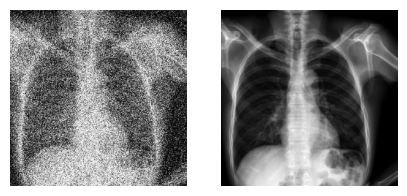

In [6]:
plt.figure(figsize=(5,5))

plt.subplot(1,2,1)
plt.imshow(data[0],cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(data[1],cmap='gray')
plt.axis('off')

# Otsu thr

In [9]:
def otsu(img_dataset):
    
    dataset_filtered = np.zeros((len(img_dataset), 256, 256), dtype='uint8')

    for i in range(len(dataset_filtered)):
        th = filters.threshold_otsu(img_dataset[i])
        dataset_filtered[i, :, :] = (img_dataset[i] > th)

    return dataset_filtered

In [10]:
thr_data = otsu(data)

(-0.5, 255.5, 255.5, -0.5)

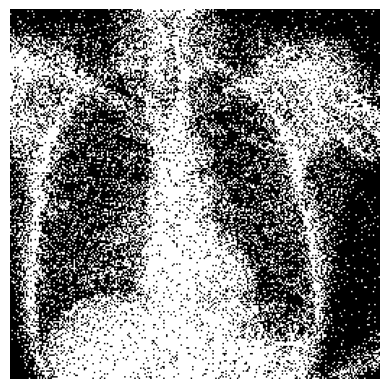

In [12]:
plt.imshow(thr_data[0], cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

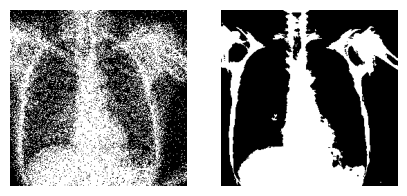

In [11]:
plt.figure(figsize=(5,5))

plt.subplot(1,2,1)
plt.imshow(thr_data[0],cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(thr_data[1],cmap='gray')
plt.axis('off')

# Middle rect strategy

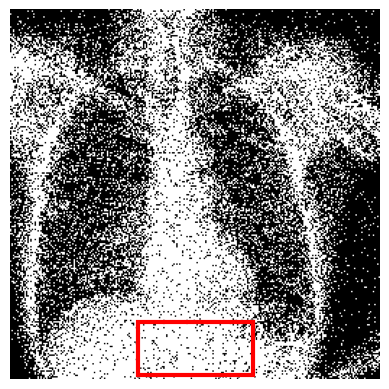

In [14]:
img = thr_data[0]
plt.imshow(img, cmap = 'gray')
plt.axis('off')

ax = plt.gca()
rect = Rectangle((128-40, 216), 80, 37, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.savefig('ROI.jpeg')

# Algorithm

In [15]:
roi_crop = thr_data[:, 216:, (128-40):(128+40)]
del thr_data

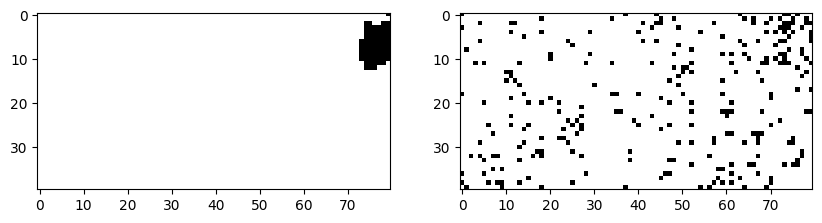

In [16]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(roi_crop[1], cmap='gray')

plt.subplot(122)
plt.imshow(roi_crop[0], cmap='gray')


Here is how the algorithm works (example in 1d) <br><br>
$ x = [1, 0, 0, 1, 1] \rightarrow 2 \, \text{flips}$ <br>
$ y = [0, 0, 1, 1, 1] \;\;(y_i = x_{i+1}\;\; \text{with}\;\; y_{end} = x_{end})$ <br><br>
$ z = |x-y| = [1, 0, 1, 0, 0] $ <br><br>
$ flips = sum(z) = 2 $ <br> <br>
same thing can be done in 2d

In [17]:
A = np.array([[1,0,1,0], [0,1,1,0]])
B = np.append(A[:,1:], np.expand_dims(A[:,-1], axis=-1),axis=1)

In [18]:
A

array([[1, 0, 1, 0],
       [0, 1, 1, 0]])

In [19]:
B

array([[0, 1, 0, 0],
       [1, 1, 0, 0]])

In [20]:
abs(A-B)

array([[1, 1, 1, 0],
       [1, 0, 1, 0]])

In [21]:
np.sum(np.abs(A-B))

5

In [28]:
def predict(arr):
    arr = arr.astype('float16')
    arr2 = np.append(arr[:,:,1:], np.expand_dims(arr[:,:,-1], axis=-1),axis=2)
    
    flips = np.sum(np.abs(arr-arr2), axis=(1,2)) / (arr.shape[1]*arr.shape[2])
    return flips

# Split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    roi_crop, y, test_size=0.30, random_state=42, stratify=y)


In [25]:
X_train.shape

(10829, 40, 80)

In [26]:
X_test.shape

(4641, 40, 80)

# Predict

In [29]:
predictions = predict(X_train)

In [31]:
prec = []
rec = []
f1 = []

thrs = np.arange(0,1,0.01)
for i in thrs:
    prec.append(precision_score(y_train,predictions>=i, zero_division=0))
    rec.append(recall_score(y_train,predictions>=i))
    f1.append(f1_score(y_train,predictions>=i))

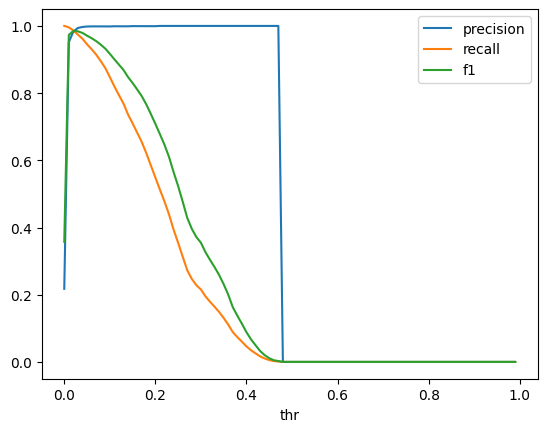

In [32]:
plt.plot(thrs, prec, label='precision')
plt.plot(thrs, rec, label='recall')
plt.plot(thrs, f1, label='f1')
plt.xlabel('thr')
plt.legend()

In [36]:
thrs[prec.index(max(prec))]

0.21

In [37]:
thrs[f1.index(max(f1))]

0.02

In [38]:
thrs[rec.index(max(rec))]

0.0

# Evaluate

In [39]:
def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions)
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['normal', 'negative'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits=4))

In [40]:
predictions = predict(X_test)

              precision    recall  f1-score   support

           0     0.9975    0.9945    0.9960      3632
           1     0.9804    0.9911    0.9857      1009

    accuracy                         0.9938      4641
   macro avg     0.9890    0.9928    0.9909      4641
weighted avg     0.9938    0.9938    0.9938      4641



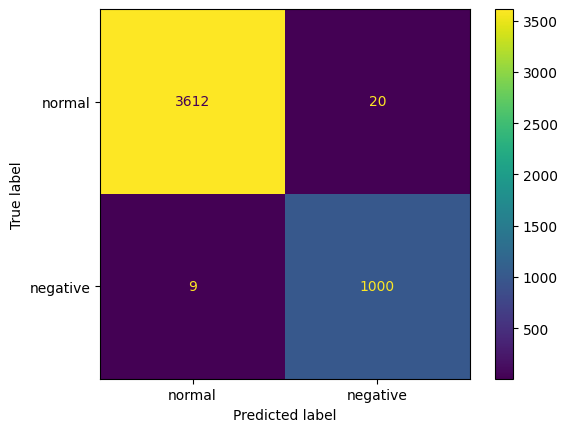

In [41]:
print_evaluation(y_test, predictions>=0.02)

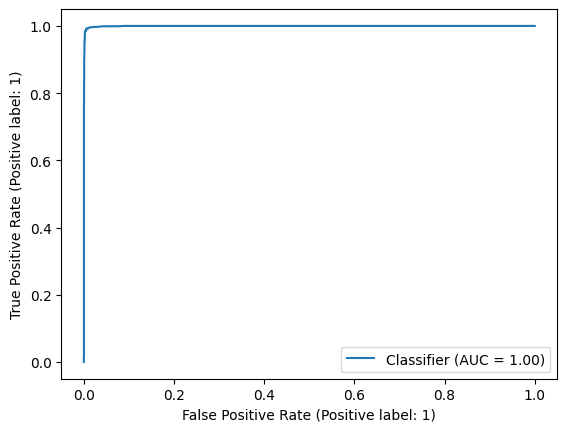

In [42]:
RocCurveDisplay.from_predictions(y_test,predictions)

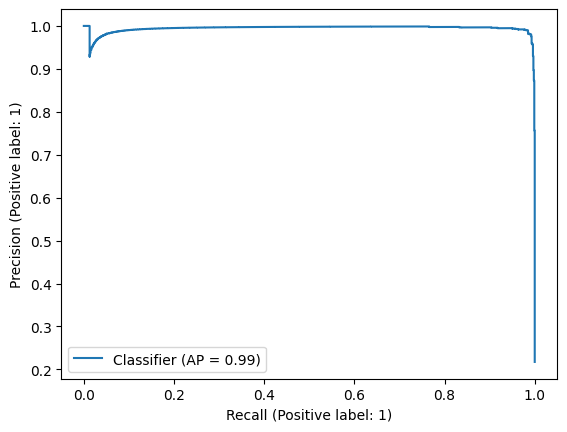

In [43]:
PrecisionRecallDisplay.from_predictions(y_test,predictions)